<a href="https://colab.research.google.com/github/GITBSB/ML-A5/blob/main/Linear_Regression_onFish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression on Fish Data

The following data-set contains the number of fish groups of camper caught in a state park (taken from https://stats.idre.ucla.edu/r/dae/zip/). Your task here is to predict the number of fish caught by a fishing party from the following information: 

* how many people are in the group
* the number children in the group
* the use of live bait
* whether the group came with a camper to the park. 

We have a small data set, of 250 groups, which visited a state park and provided. For comparison the data set is already split into a training set and testset.

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import tensorflow as tf
from math import log
%load_ext version_information

  Created wheel for version-information: filename=version_information-1.0.3-cp36-none-any.whl size=3881 sha256=38b2d888274a56065d3cbd3d3d84e90e88243eb088558dd79fa9fadadd0669e7
  Stored in directory: /root/.cache/pip/wheels/1f/4c/b3/1976ac11dbd802723b564de1acaa453a72c36c95827e576321
Successfully built version-information


In [4]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
import os
from urllib.request import urlretrieve
if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz',filename = 'fishing.npz')
d = np.load('fishing.npz')
Xt = d['Xt'] #"livebait","camper","persons","child"
Xte = d['Xte']
yt = d['yt']
yte = d['yte']
xtrain= pd.DataFrame(Xt)
xtrain

,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0
2,1.0,1.0,3.0,0.0
3,1.0,1.0,3.0,2.0
4,1.0,1.0,4.0,1.0
...,...,...,...,...
195,1.0,1.0,1.0,0.0
196,1.0,1.0,1.0,0.0
197,1.0,1.0,3.0,0.0
198,1.0,0.0,1.0,0.0


a) Do a linear regression by creating a design matrix with the intercept term and use the fomulae given in the lecture to determine the coefficients on the training set.

b) Repeat a) but this time with `LinearRegression` from `sklearn.linear_model`

Result: array([-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051])
Don't forget the intercept, you should have 5 numbers!

c) Determine the Root Mean Square Error (RMSE) and the average negative log-likelihood (NLL) on the testset. For NLL we assume that the conditional probability distrubution (CPD) $p(y|x)$ is given by the density of a Gaussian with constant variance $\sigma^2$. Estimate $\sigma^2$ using the variance of the residuals. Use the variance estimation with $1/N$. 

Result: $ RMSE \approx 8.58812$, $\hat \sigma^2 \approx 73.7559$, $\tt{NLL} \approx 3.569$

d) For the testset: plot the predicted mean number of fish caught ($\mu$) against observed number of fish caught. Further include the 2.5 and 97.5 precentile of p(y|x), the conditional predictive distribution (CPD) of $y$ for a given $x$. Why is a Gaussian not ideal for that kind of data? 

Hint: For the Gaussian the 2.5% and the 97.5% percentile is approximatiy given by $\mu \pm 1.96*\sigma$

e) This data is count data. Count data has only positive values and also the distribution is discrete. You cannot catch 0.5 fish and that the CPD has probability density > 0 on negative number of fish is wrong too. A Gaussian as a CPD is therefore not ideal. 

Now use a Poissonian as CPD. If we assume a Poissonian then the probability to catch $k$ fish is given by 
$$
  p(k) = \exp(-\mu) \frac{\mu^k}{k!}
$$

and the NLL is thus by:

$$
 log(p(k)) = -\mu  + k \cdot \log(\mu) - log(k!)
$$

with $\mu$ being the expectation. In our case the average number of fish expected.

In the case of the probabilistic interpretation of the linear regression, $y_i$ for a given $x_i$ is distributed like a Gaussian. The paramter $\mu_i$ from $N(\mu_i,\sigma^2)$ has been determined from $x_i$ via $\mu_i= \beta^T \cdot x_i$ by minimizing the NLL. 

A small additional detail: For the Poissonian case, $\mu_i$ needs to be positive. We therefore do not use $\beta^T \cdot x_i$ directly but "pipe it through" an exponential first to make it positive and thus link $\mu_i=exp(\beta^T \cdot x_i)$ to the data.

Use a gradient descent approach on the NLL to find the solution for the parameters. Calculate the RMSE and the NLL on the test set and compare with c).

Hint: On the trainingset for the parameter values (1,1,1,1,1) the NLL should be approx 1508 and the gradient (1518.61, 1403.99, 1171.02, 5701.91, 3258.7). For the NLL a good learning rate would be 0.001 and training should be done for at least 5000 epochs.

f) Do the same plot as in d) but this time with a Poisson CPD. Hint you can use scipy.stats.poisson to calculate the percentiles.

**Aufgabe a): Design matrix with the intercept term**

In [5]:
xtrain.insert(0, 'Intercept',np.ones((200,1)))
xtrain

,Intercept,0,1,2,3
0,1.0,1.0,0.0,4.0,0.0
1,1.0,1.0,1.0,2.0,0.0
2,1.0,1.0,1.0,3.0,0.0
3,1.0,1.0,1.0,3.0,2.0
4,1.0,1.0,1.0,4.0,1.0
...,...,...,...,...,...
195,1.0,1.0,1.0,1.0,0.0
196,1.0,1.0,1.0,1.0,0.0
197,1.0,1.0,1.0,3.0,0.0
198,1.0,1.0,0.0,1.0,0.0


In [6]:
X = np.asmatrix(xtrain.iloc[:,0:5])
print(X[0:3])

[[1. 1. 0. 4. 0.]
 [1. 1. 1. 2. 0.]
 [1. 1. 1. 3. 0.]]


In [37]:
### fomulae given in the lecture to determine the coefficients on the training set
XTX = np.matmul(X.T,X) 
XTXI = np.linalg.inv(XTX)
XTXIXT = np.matmul(XTXI, X.T)
w = np.matmul(XTXIXT,yt)
w

matrix([[-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051]])

**Aufgabe b): LinearRegression from sklearn.linear_model**

In [8]:
from sklearn.linear_model import LinearRegression
model_skl = LinearRegression(fit_intercept=True) 
model_skl.fit(Xt,yt)
intercept = model_skl.intercept_,
model_skl.coef_ 

result = np.append(intercept, model_skl.coef_, axis=0)
result

array([-8.492231 ,  2.4822128,  2.9543095,  4.6495404, -5.4716005],
      dtype=float32)

**Aufgabe c): RMSE, Varianz & NLL**

In [9]:
# RMSE without sklearn
w = np.asarray(w).flatten()
Xte_I = np.hstack((np.ones((Xte.shape[0], 1), dtype=Xte.dtype), Xte))
y_hat = Xte_I.dot(w.T)
RMSE = np.sqrt(np.mean((yte - y_hat.flatten())**2))
RMSE

8.58812638673423

In [10]:
# RMSE with sklearn
from sklearn.metrics import mean_squared_error
y_hat = model_skl.predict(Xte) 
RMSE = np.sqrt(mean_squared_error(yte, y_hat))
RMSE

8.588127

In [53]:
y_hat

array([ 5.4563904 ,  2.4670029 , 10.10593   ,  3.2890625 , -1.3604784 ,
       -2.182538  ,  5.4213123 ,  2.4670029 ,  1.593832  ,  6.243372  ,
       -2.182538  ,  1.6449423 ,  6.243372  ,  6.243372  , -3.0045977 ,
       -2.182538  ,  3.761159  ,  1.593832  , -1.3604784 , 10.892912  ,
        0.77177143,  2.4670029 , -3.0045977 ,  1.593832  ,  6.243372  ,
        1.593832  , -0.8883815 ,  7.116543  , -1.3604784 , -2.182538  ,
        3.2890625 , 10.070852  ,  0.77177143,  1.6449423 ,  6.243372  ,
        6.243372  ,  0.77177143, -1.3604784 , 10.892912  , 15.542452  ,
        2.9390993 ,  1.6449423 , 10.070852  , 10.070852  ,  0.77177143,
        7.116543  , 15.542452  ,  0.77177143,  3.2890625 ,  5.4213123 ],
      dtype=float32)

In [38]:
# Varianz der Residuen
residuals= yte-y_hat.flatten()
n = residuals.size
meanre = residuals.mean()
variance = sum((residuals-meanre)**2/n)
variance

73.48030588678375

In [39]:
yte.shape[0]

50

Negative Log Likelihood

In [40]:
import scipy.stats
# Normalverteilung der vorhergesagten Werte berechnen -> Wahrscheinlichkeit des Testwertes(tatsächlicher Wert)
# negierter Logarithmus des Wertes zur GesamtNLL hinzufügen
totalNLL = 0
n = yte.shape[0]
for i in range (n):
  norm = scipy.stats.norm(loc=y_hat[i], scale=np.sqrt(variance))
  totalNLL += -np.log(norm.pdf(yte[i]))
totalNLL / n

3.5693226818656023

**Aufgabe d): plot the predicted mean number of fish caught ( 𝜇 ) against observed number of fish caught**

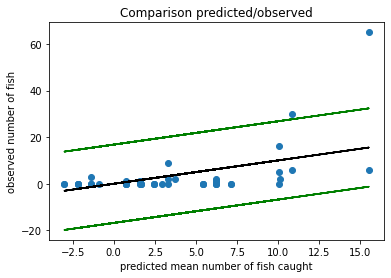

In [51]:
plt.scatter(y_hat, yte)
plt.plot(y_hat, y_hat, c="black")
###2.5 and 97.5 precentile 
plt.plot(y_hat.flatten(), y_hat.flatten()+1.96*np.sqrt(variance),c="green")
plt.plot(y_hat.flatten(), y_hat.flatten()-1.96*np.sqrt(variance),c="green")

plt.title("Comparison predicted/observed")
plt.xlabel('predicted mean number of fish caught')
plt.ylabel('observed number of fish')
plt.show()

Warum Gaussian schlecht?: Beachtet auch negative Werte, bei Zähldaten führt dies zu falschen Ergebnissen

**Aufgabe d) Poisson: Use a gradient descent approach on the NLL to find the solution for the parameters**

In [24]:
import math

def nll_loss(x, y, w):
  y_hat = x.dot(w.T)
  y_hat_exp = np.exp(y_hat)

  n = y.shape[0]
  totalNLL = 0

  for i in range(n):
    # Berechne NLL
    totalNLL += (-y_hat_exp[i] + y[i] * np.log(y_hat_exp[i]) - log(math.factorial(y[i])))
  return -totalNLL / n

In [25]:
nll_loss(np.asarray(X), yt, np.array([1,1,1,1,1]))

1507.9856602262093

In [26]:
def calcGrad(x, y , w):
  y_hat = x.dot(w.T)
  y_hat_exp = np.exp(y_hat)
  sumofGrad=np.zeros(len(w))

  for i in range(y.shape[0]):
    for j in range(w.shape[0]):
      # Berechne die jeweiligen Gradienten mit Ableitung der NLL Formel
      sumofGrad[j] = sumofGrad[j] + (x[i,j] * ((y_hat_exp[i])-y[i]))
              
  return sumofGrad / y.shape[0]

In [27]:
x = np.asarray(X)
y = yt
ws = np.array([1,1,1,1,1])
learning_rate = 0.001
epochs = 5000
grads = calcGrad(x, y, ws)

for i in range(epochs):   
  ws = (ws - learning_rate * np.asarray(grads))
  grads = calcGrad(x, y, ws)

print(ws) # Koeffizienten
print("NLL: ", nll_loss(x, y, ws)) # NLL

[-1.08852056  0.2597268   0.54509109  0.85448041 -1.65101241]
NLL:  3.491753672786516


Berechne für Testdaten

In [28]:
yte_hat_poisson = np.exp(Xte_I.dot(ws.T))
yte_hat_poisson

array([ 4.37068903,  1.08723204, 10.27178771,  2.4113025 ,  1.02601939,
        0.46262182,  1.8752203 ,  1.08723204,  1.76964283,  4.15893132,
        0.46262182,  0.49022199,  4.15893132,  4.15893132,  0.20859153,
        0.46262182,  3.2076268 ,  1.76964283,  1.02601939,  9.77412471,
        0.79791415,  1.08723204,  0.20859153,  1.76964283,  4.15893132,
        1.76964283,  1.36485874,  2.5551616 ,  1.02601939,  0.46262182,
        2.4113025 ,  4.40705452,  0.79791415,  0.49022199,  4.15893132,
        4.15893132,  0.79791415,  1.02601939,  9.77412471, 22.97068801,
        1.44628666,  0.49022199,  4.40705452,  4.40705452,  0.79791415,
        2.5551616 , 22.97068801,  0.79791415,  2.4113025 ,  1.8752203 ])

In [29]:
# RMSE
np.sqrt(mean_squared_error(yte, yte_hat_poisson))

7.606839288683508

In [31]:
# NLL
nll_loss(Xte_I, yte, ws)

3.0692866711267768

**Aufgabe e): Plot**

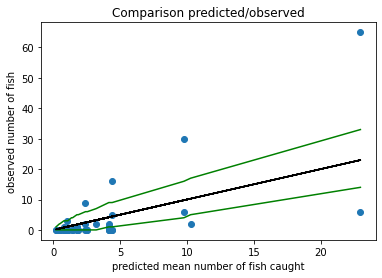

In [52]:
from scipy.stats import poisson
###percentiles
per1 =poisson.ppf(0.025, yte_hat_poisson)
per2 =poisson.ppf(0.975, yte_hat_poisson)


plt.scatter(yte_hat_poisson, yte)
plt.title("Comparison predicted/observed")
plt.xlabel('predicted mean number of fish caught')
plt.ylabel('observed number of fish')
plt.plot(yte_hat_poisson[np.argsort(yte_hat_poisson,axis=0)].flatten(), per1[np.argsort(yte_hat_poisson,axis=0)],c="green")
plt.plot(yte_hat_poisson[np.argsort(yte_hat_poisson,axis=0)].flatten(), per2[np.argsort(yte_hat_poisson,axis=0)],c="green")
plt.plot(yte_hat_poisson, yte_hat_poisson, c="black")

In [56]:
%version_information numpy

Software versions
Python 3.6.9 64bit [GCC 8.4.0]
IPython 5.5.0
OS Linux 4.19.112+ x86_64 with Ubuntu 18.04 bionic
numpy 1.18.5
Sat Nov 28 15:44:32 2020 UTC